In [1]:
import torch
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import deepxde.deepxde as dde
from datasets import makeTesting_dr
from datasets import parallel_solver, diffusion_reaction_solver
from utils.func import dirichlet, periodic, H1norm
from utils.PDETriple import PDETripleCartesianProd

date = time.strftime("%Y%m%d-%H-%M-%S", time.localtime())
# dde.config.set_random_seed(2023)

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


In [2]:
total_training_vx = 300
ls = 0.05

check_num = 1000
select_num = 20
solver_worker = 0

lr_start = 5e-3
lr_middle = 5e-3
lr_end = 5e-3

iter_start = 20000
iter_middle = 40000
iter_end = 60000

batch_start = lambda n: 2
batch_middle = lambda n: n // 5
batch_end = lambda n: n

decay_start = None
decay_middle = None
decay_end = None

if False:
    makeTesting_dr(length_scale = ls)

In [3]:
def pde(x, y, aux):
    D = 0.01
    k = 0.01
    dy_t = dde.grad.jacobian(y, x[1], j=1)
    dy_xx = dde.grad.hessian(y, x[1], j=0)
    out = dy_t - D * dy_xx + k * y**2 - aux
    return out

class boundary():
    def __init__(self, loss_coeff = 1, value = 0):
        self.loss_coeff = loss_coeff
        self.value = value
    
    def __call__(self, targets, outputs):
        return self.loss_coeff * (outputs - self.value).abs().mean()

In [4]:
space = dde.data.GRF(1.0, length_scale = ls, N= 1000, interp="cubic")

geom = dde.geometry.Interval(0, 1)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)
vxs = space.eval_batch(space.random(select_num), np.linspace(0, 1, 101)[:, None])
uxts = parallel_solver(diffusion_reaction_solver, vxs, num_workers = solver_worker)
grid = uxts[0][0].reshape(101 * 101, -1)
uxts = np.asarray([u for grid, u in uxts]).reshape(-1, 101 * 101)


train_vxs = vxs
train_grid = grid
train_uxts = uxts
print(train_vxs.shape, train_grid.shape, train_uxts.shape)

test_data = np.load(f"datasets/DF_100_{ls:.2f}_101_101.npz")
test_vxs = test_data["vxs"]
test_grid = test_data["xt"].reshape(-1, 2)
test_uxts = test_data["uxts"].reshape(-1, 101 * 101)
del test_data
print(test_vxs.shape, test_grid.shape, test_uxts.shape)

(20, 101) (10201, 2) (20, 10201)
(100, 101) (10201, 2) (100, 10201)


In [5]:
init_indices = (grid[:, 1] == 0).nonzero()[0]
bound_indices = np.logical_or(grid[:, 0] == 0, grid[:, 0] == 1).nonzero()[0]
boundary_losses = []
boundary_losses.append((init_indices, boundary()))
boundary_losses.append((bound_indices, boundary()))
print(init_indices.shape, bound_indices.shape)

(101,) (202,)


In [6]:
data = PDETripleCartesianProd(X_train=(train_vxs, train_grid), y_train=train_uxts, X_test=(test_vxs, test_grid), y_test=test_uxts, boundary = [])

# Net
net = dde.nn.DeepONetCartesianProd(
    [101, 100, 100],
    [2, 100, 100, 100],
    "gelu",
    "Glorot normal",
)

# net.apply_feature_transform(periodic)
net.apply_output_transform(dirichlet)

model = dde.Model(data, net)
model.compile("adam", 
              lr= lr_start, 
              loss= ["mse"], 
              metrics = ["mean l2 relative error"], 
              decay = decay_start)


Compiling model...
'compile' took 0.000793 s



Training model...

Step      Train loss    Test loss     Test metric   
0         [2.76e-01]    [1.77e-01]    [1.02e+00]    
1000      [3.74e-02]    [4.97e-02]    [5.66e-01]    
2000      [6.40e-02]    [1.34e+00]    [2.16e+00]    
3000      [3.62e-02]    [1.00e+00]    [1.89e+00]    
4000      [3.08e-02]    [8.34e-01]    [1.73e+00]    
5000      [1.55e-02]    [6.73e-01]    [1.61e+00]    
6000      [1.19e-02]    [4.95e-01]    [1.43e+00]    
7000      [1.11e-02]    [3.91e-01]    [1.27e+00]    
8000      [1.16e-02]    [3.01e-01]    [1.16e+00]    
9000      [2.15e-03]    [1.77e-01]    [9.51e-01]    
10000     [5.80e-03]    [2.11e-01]    [9.89e-01]    
11000     [4.59e-03]    [2.72e-01]    [1.09e+00]    
12000     [4.40e-03]    [1.65e-01]    [9.20e-01]    
13000     [3.62e-03]    [2.10e-01]    [1.00e+00]    
14000     [4.27e-03]    [5.16e-02]    [5.67e-01]    
15000     [4.01e-03]    [4.92e-02]    [5.50e-01]    
16000     [1.68e-03]    [4.60e-02]    [5.26e-01]    
17000     [9.73e-04]    [4.

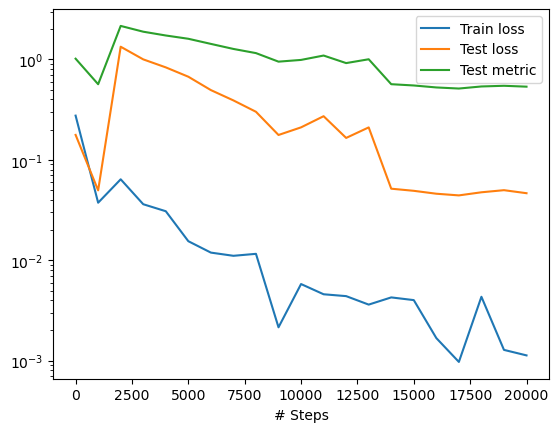

In [7]:
losshistory, train_state = model.train(iterations = iter_start, batch_size = batch_start(len(train_vxs)))
dde.utils.plot_loss_history(losshistory)

In [8]:
losshistory.to_pandas().to_csv(f"results/loss_history_{date}_h1.csv", index=False)

fig, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(15,5))

v = test_vxs[1]
x = np.linspace(0,1,v.shape[0])

ax1.set_xlim(0,1)
ax1.scatter(x, v, s=1)

ut = test_uxts[0]
xt = test_grid

ax2.set_xlim(0,1)
ax2.set_ylim(0,1)
ax2.set_aspect('equal')
ax2.scatter(xt[...,0], xt[...,1], c=ut)

out = model.predict((test_vxs[(0,),...], xt))

ax3.set_xlim(0,1)
ax3.set_ylim(0,1)
ax3.set_aspect('equal')
ax3.scatter(xt[...,0], xt[...,1], c=out)

plt.tight_layout()
plt.show()

196.10807386324234 35.21951145632975
40
Compiling model...
'compile' took 0.000362 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [2.19e-02]    [4.66e-02]    [5.36e-01]    
1000      [9.47e-04]    [2.20e-02]    [3.77e-01]    
2000      [3.34e-04]    [1.98e-02]    [3.59e-01]    
3000      [6.10e-04]    [1.99e-02]    [3.58e-01]    
4000      [3.55e-04]    [1.74e-02]    [3.42e-01]    
5000      [1.24e-03]    [1.69e-02]    [3.35e-01]    
6000      [4.43e-04]    [1.72e-02]    [3.41e-01]    
7000      [7.03e-04]    [1.77e-02]    [3.45e-01]    
8000      [4.50e-04]    [1.65e-02]    [3.35e-01]    
9000      [2.25e-04]    [1.61e-02]    [3.30e-01]    
10000     [8.73e-05]    [1.65e-02]    [3.35e-01]    
11000     [3.05e-04]    [1.62e-02]    [3.35e-01]    
12000     [1.11e-04]    [1.63e-02]    [3.34e-01]    
13000     [9.16e-05]    [1.64e-02]    [3.36e-01]    
14000     [1.48e-04]    [1.60e-02]    [3.32e-01]    
15000     [4.63e-05]    [1.63e-02]    [3.35e-01

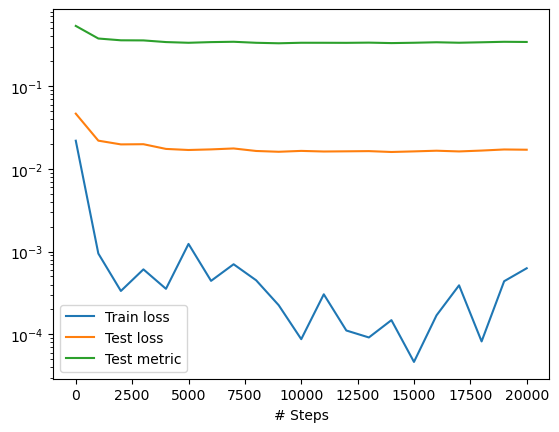

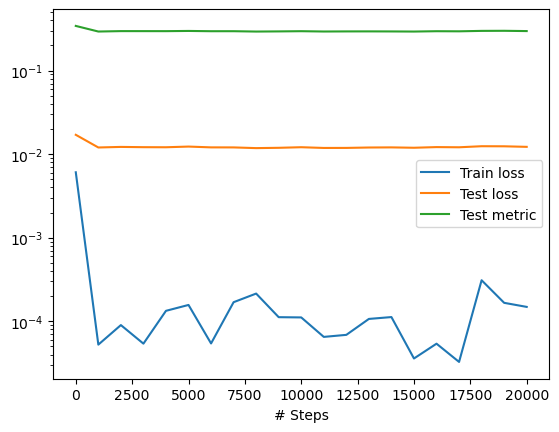

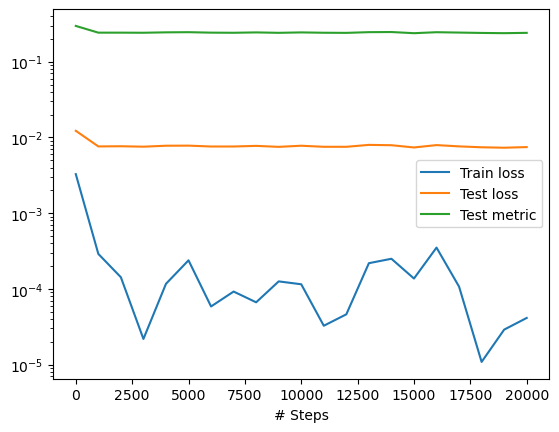

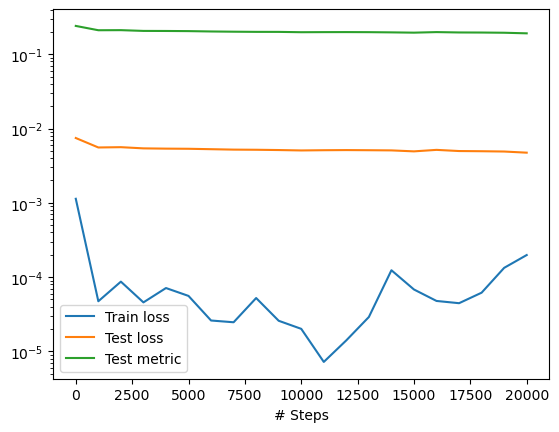

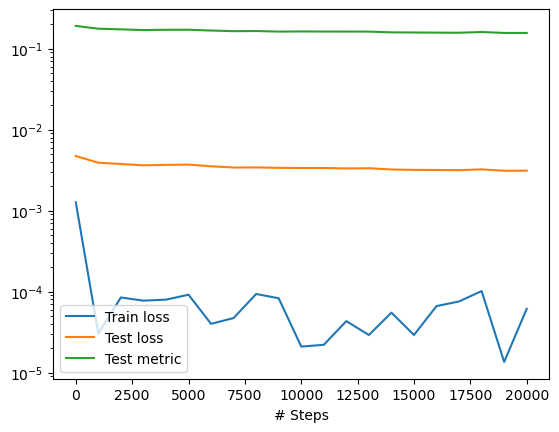

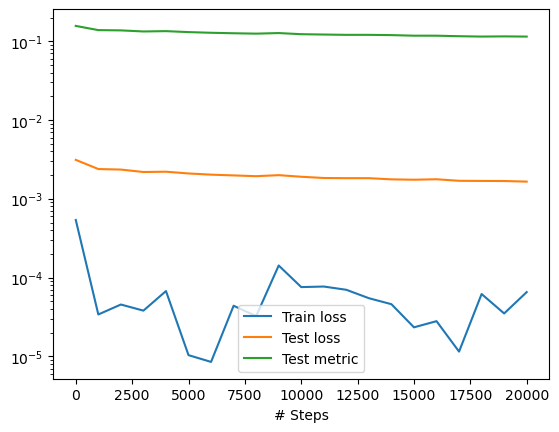

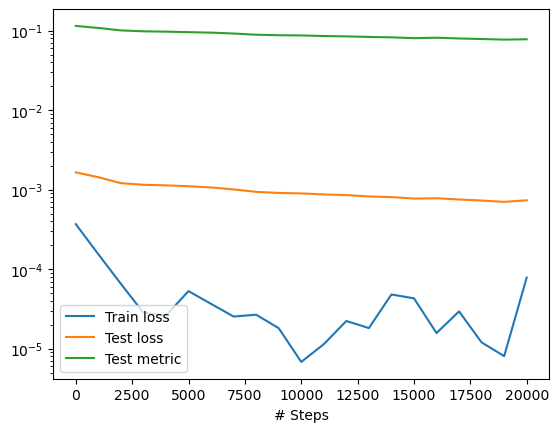

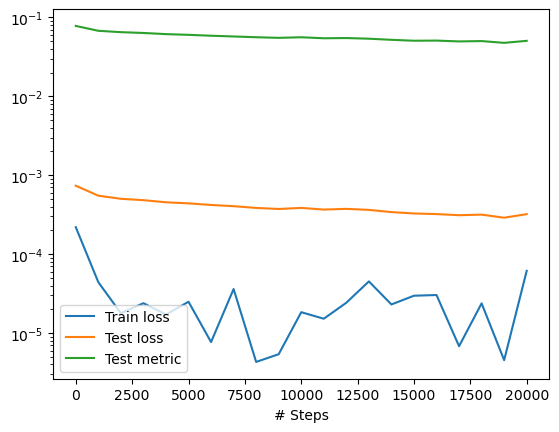

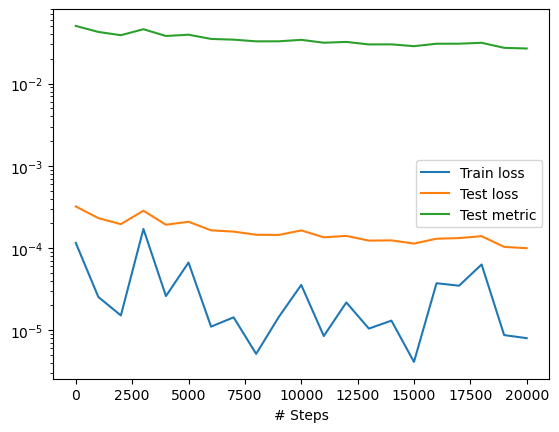

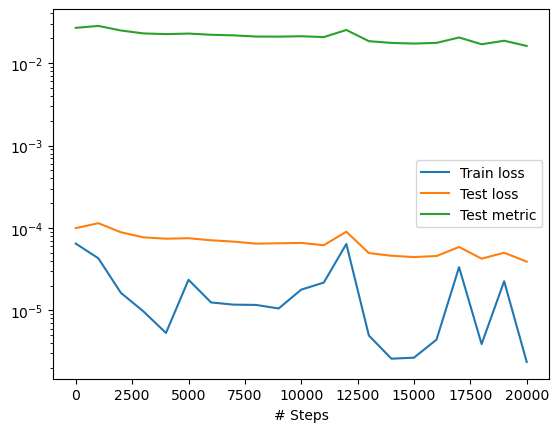

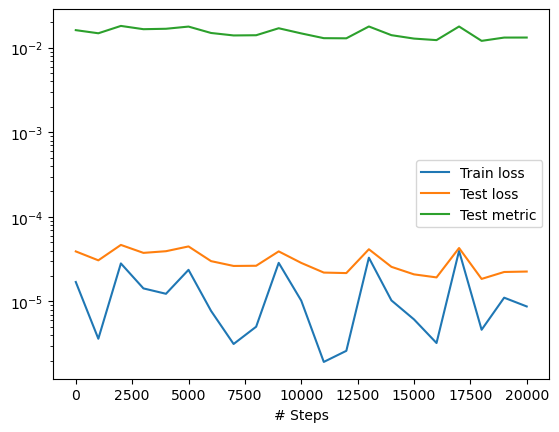

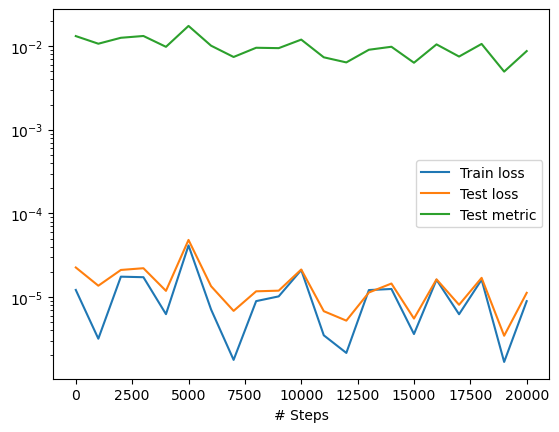

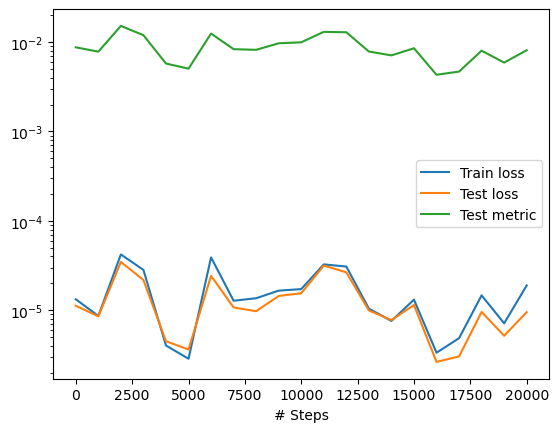

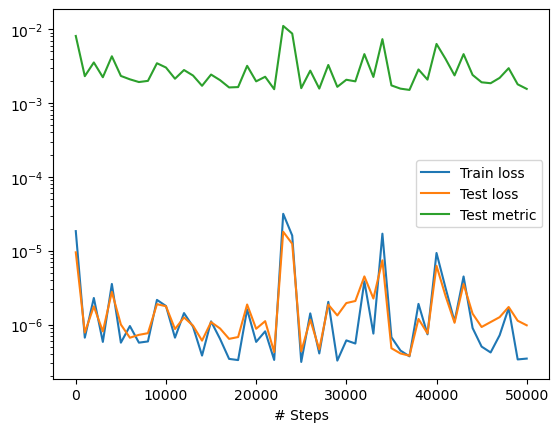

: 

In [9]:

while len(train_vxs) < total_training_vx:
    # generate some vxs to test
    pde_data = dde.data.TimePDE(geomtime, pde, [], num_domain = 20000)
    eval_pts = np.linspace(0, 1, 101)[:, None] # generate 1000 random vxs
    geom = dde.geometry.Interval(0, 1)
    timedomain = dde.geometry.TimeDomain(0, 1)
    geomtime = dde.geometry.GeometryXTime(geom, timedomain)
    func_space = dde.data.GRF(1.0, length_scale = ls, N= 1000, interp="linear")
    testing_new_data = dde.data.PDEOperatorCartesianProd(pde_data, func_space, eval_pts, check_num, [0])
    # testing_model = dde.Model(testing_new_data, net)
    a, _, c = testing_new_data.train_next_batch()
    h1 = H1norm(a[0])
    print(np.mean(h1), np.std(h1))
    topk_index = np.argpartition(h1, -select_num)[-select_num:] # select the top 20 vxs
    topk_vxs = a[0][topk_index]
    uxts = parallel_solver(diffusion_reaction_solver, topk_vxs, num_workers = solver_worker)
    uxts = np.asarray([u for grid, u in uxts]).reshape(-1, 101 * 101)

    # then add the new data to the training set, and train the model
    train_vxs = np.concatenate([train_vxs, topk_vxs], axis = 0)
    train_uxts = np.concatenate([train_uxts, uxts], axis = 0)
    
    print(len(train_vxs))
    data = PDETripleCartesianProd(X_train=(train_vxs, train_grid), y_train=train_uxts, X_test=(test_vxs, test_grid), y_test=test_uxts, boundary = [])

    
    model = dde.Model(data, net)
    lr = lr_middle if len(train_vxs) != total_training_vx else lr_end
    decay = decay_middle if len(train_vxs) != total_training_vx else decay_end
    batchsize = batch_middle(len(train_vxs)) if len(train_vxs) != total_training_vx else batch_end(len(train_vxs))
    iterations = iter_middle if len(train_vxs) != total_training_vx else iter_end
    model.compile("adam", 
                  lr = lr, 
                  metrics = ["mean l2 relative error"],
                  decay = decay,)

    losshistory, train_state = model.train(iterations=iterations, batch_size = batchsize)
    pd_frame = losshistory.to_pandas()
    pd_frame = pd.concat([pd.read_csv(f"results/loss_history_{date}_h1.csv"), pd_frame], axis = 0, ignore_index=True)
    pd_frame.to_csv(f"results/loss_history_{date}_h1.csv", index=False)
    dde.utils.plot_loss_history(losshistory)
    plt.show()

torch.save(model.state_dict(), f"results/model_{date}_h1.pth")